In [21]:
# Python vision: Python3.5
# @Author: MingZZZZZZZZ
# @Date created: 2019
# @Date modified: 2019
# Description:

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

from statsmodels.stats.stattools import durbin_watson

# example: **************************************************************
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')

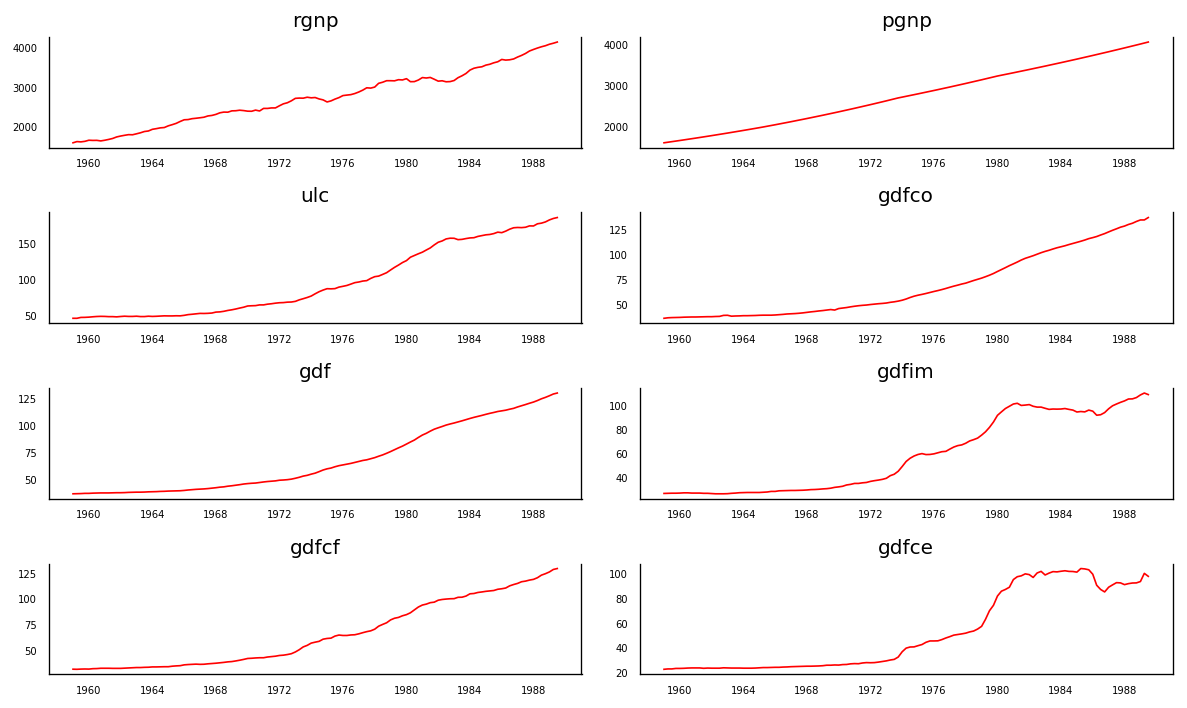

In [22]:
# plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()
plt.show()

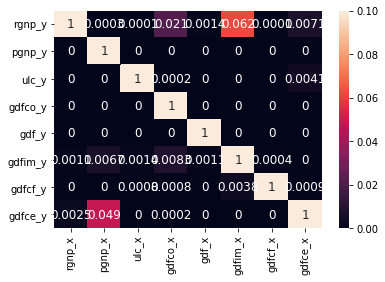

In [23]:
# Granger's causality test
def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.
    :param data: dataframe
        pandas dataframe containing the time series variables
    :param variables : list
        list containing names of the time series variables.
    :param maxlag: int
        the Granger causality test results are calculated for all lags up to maxlag
    :param verbose: bool
        print results if true
    :return: dataframe
        If a given p-value is < significance level (0.05), then, the corresponding X series (column)
        causes the Y (row)
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose:
                print('Y = {}, X = {}, P Values = {}'.format(r, c, p_values))
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


causality_df = grangers_causation_matrix(df, variables=df.columns, verbose=False)
sns.heatmap(causality_df, annot=True, annot_kws={'size': 12}, vmax=0.1)
plt.show()


In [24]:
def adjust(val, length= 6): return str(val).ljust(length)
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]

    # Summary
    print('Name :: Test Stat > C(95%) => Signif \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' => ', trace > cvt)


cointegration_test(df)

Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>  True
pgnp   ::  183.12    > 111.7797  =>  True
ulc    ::  130.01    > 83.9383   =>  True
gdfco  ::  85.28     > 60.0627   =>  True
gdf    ::  55.05     > 40.1749   =>  True
gdfim  ::  31.59     > 24.2761   =>  True
gdfcf  ::  14.06     > 12.3212   =>  True
gdfce  ::  0.45      > 4.1296    =>  False


In [25]:
# split dataset
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]
# Check size
print(df_train.shape)
print(df_test.shape)

# do difference until all variable is stationary
df_diff = df_train.diff().dropna()
# Second Differencing
df_diff = df_diff.diff().dropna()

(119, 8)
(4, 8)


In [26]:
# ADF Test (stationarity check) 
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    # Print Summary
    print('Augmented Dickey-Fuller Test on "{}"'.format(name), "\n", '-'*47)
    print(' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(' Significance Level = {}'.format(signif))
    print(' Test Statistic = {}'.format(output["test_statistic"]))
    print(' No. Lags Chosen = {}'.format(output["n_lags"]))
    
    for key,val in r[4].items():
        print(' Critical value {} = {}'.format(adjust(key), round(val, 3)))
    if p_value <= signif:
        print(" => P-Value = {}. Rejecting Null Hypothesis.".format(p_value))
        print(" => Series is Stationary.")
    else:
        print(" => P-Value = {}. Weak evidence to reject the Null Hypothesis.".format(p_value))
        print(" => Series is Non-Stationary.")


for name, column in df_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

Augmented Dickey-Fuller Test on "rgnp" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -9.0123
 No. Lags Chosen = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "pgnp" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -10.9813
 No. Lags Chosen = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Augmented Dickey-Fuller Test on "ulc" 
 -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level = 0.05
 Test Statistic = -8.769
 No. Lags Chosen = 2
 Critical va

In [27]:
# model*******************************************************
model = VAR(df_diff)
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  -1.3679402315450673
BIC :  0.3411847146588829
FPE :  0.2552682517347195
HQIC:  -0.6741331335699563 

Lag Order = 2
AIC :  -1.6212373944478262
BIC :  1.6249432095295826
FPE :  0.20113494371371346
HQIC:  -0.30362888267959454 

Lag Order = 3
AIC :  -1.7658008387012765
BIC :  3.034547316376786
FPE :  0.18125103746164412
HQIC:  0.18239143783963563 

Lag Order = 4
AIC :  -2.000735164470317
BIC :  4.371215137654088
FPE :  0.1555696652148111
HQIC:  0.5849359332771078 

Lag Order = 5
AIC :  -1.9619535608363945
BIC :  5.999364562242096
FPE :  0.18692794389114903
HQIC:  1.2682063311783338 

Lag Order = 6
AIC :  -2.330338652482907
BIC :  7.238452689088579
FPE :  0.16380374017443636
HQIC:  1.5514371669548055 

Lag Order = 7
AIC :  -2.5923313523471254
BIC :  8.602387254937799
FPE :  0.18238685837154206
HQIC:  1.9483069621146587 

Lag Order = 8
AIC :  -3.317261976458205
BIC :  9.52219581032303
FPE :  0.15573163248209088
HQIC:  1.8896071386220985 

Lag Order = 9
AIC :  -4.80476312

/home/ming/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [28]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


In [29]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Nov, 2019
Time:                     18:17:54
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

In [30]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# If there is any correlation left in the residuals, then, there is some pattern in the time series
# that is still left to be explained by the model. In that case, the typical course of action is to
# either increase the order of the model or induce more predictors into the system or look for
# a different algorithm to model the time series.
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))


rgnp   : 2.09
pgnp   : 2.02
ulc    : 2.17
gdfco  : 2.05
gdf    : 2.25
gdfim  : 1.99
gdfcf  : 2.2
gdfce  : 2.17


In [31]:
# predict
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)
# Input data for forecasting
forecast_input = df_diff.values[-lag_order:]
print(forecast_input)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast


4
[[ 13.5   0.1   1.4   0.1   0.1  -0.1   0.4  -2. ]
 [-23.6   0.2  -2.   -0.5  -0.1  -0.2  -0.3  -1.2]
 [ -3.3   0.1   3.1   0.5   0.3   0.4   0.9   2.2]
 [ -3.9   0.2  -2.1  -0.4   0.2  -1.5   0.9  -0.3]]


,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


In [32]:
# transformation to real prediction
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast', 'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]


,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


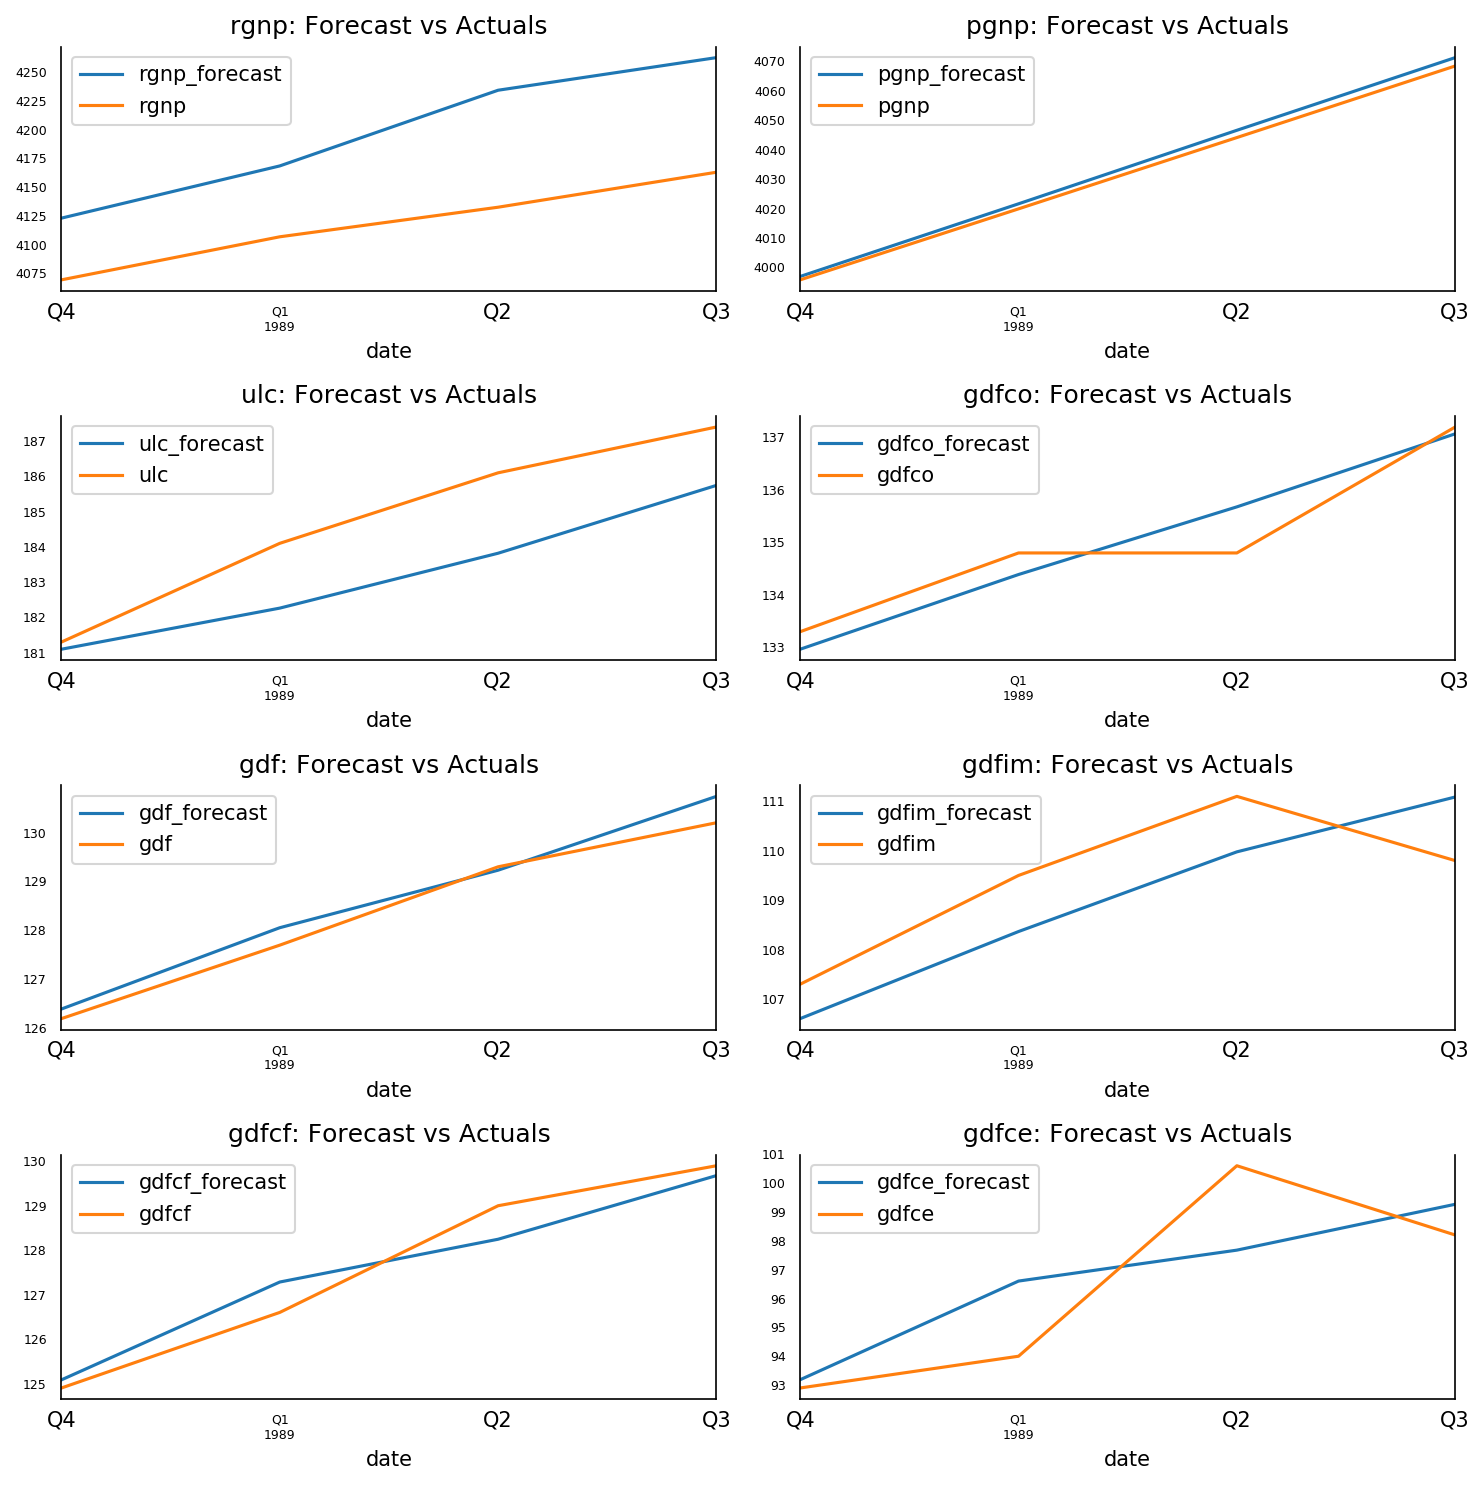

In [33]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [34]:
# Evaluation
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual)/actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5 # RMSE
    corr = np.corrcoef(forecast, actual)[0,1] # corr
    # MAPE
    mins = np.amin(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
    actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  0.0192
mae    :  79.1031
minmax :  0.0188
me     :  79.1031
corr   :  0.9849
mpe    :  0.0192
rmse   :  82.0245

Forecast Accuracy of: pgnp
mape   :  0.0005
mae    :  2.0432
minmax :  0.0005
me     :  2.0432
corr   :  1.0
mpe    :  0.0005
rmse   :  2.146

Forecast Accuracy of: ulc
mape   :  0.0081
mae    :  1.4947
minmax :  0.0081
me     :  -1.4947
corr   :  0.963
mpe    :  -0.0081
rmse   :  1.6856

Forecast Accuracy of: gdfco
mape   :  0.0033
mae    :  0.4384
minmax :  0.0032
me     :  0.0007
corr   :  0.9407
mpe    :  0.0
rmse   :  0.5169

Forecast Accuracy of: gdf
mape   :  0.0023
mae    :  0.29
minmax :  0.0022
me     :  0.2554
corr   :  0.9905
mpe    :  0.002
rmse   :  0.3392

Forecast Accuracy of: gdfim
mape   :  0.0097
mae    :  1.06
minmax :  0.0096
me     :  -0.4166
corr   :  0.807
mpe    :  -0.0038
rmse   :  1.0826

Forecast Accuracy of: gdfcf
mape   :  0.0036
mae    :  0.4604
minmax :  0.0036
me     :  -0.0271
corr   :  0.9713
mpe    :  -